In [1]:
import pandas as pd
import geopandas as gpd
from sklearn.neighbors import KDTree
import numpy as np
import statsmodels
import numpy.linalg as la
import matplotlib.pyplot as plt

In [173]:
def orthogonalize(U, eps=1e-15):
    """
    from https://gist.github.com/anmolkabra/b95b8e7fb7a6ff12ba5d120b6d9d1937
    """
    n = len(U[0])
    V = U.T
    for i in range(n):
        prev_basis = V[0:i]     # orthonormal basis before V[i]
        coeff_vec = np.dot(prev_basis, V[i].T)  # each entry is np.dot(V[j], V[i]) for all j < i 
        V[i] -= np.dot(coeff_vec, prev_basis).T
        if la.norm(V[i]) < eps:
            V[i][V[i] < eps] = 0.   # set the small entries to 0
        else:
            V[i] /= la.norm(V[i])
    return V.T

In [143]:
points_c = pd.read_parquet('coord_france_indif_indus_remar_concentrated.parquet.gzip')

In [179]:
points_d = pd.read_parquet('coord_france_indif_indus_remar_dispersed.parquet.gzip')

<AxesSubplot:xlabel='x', ylabel='y'>

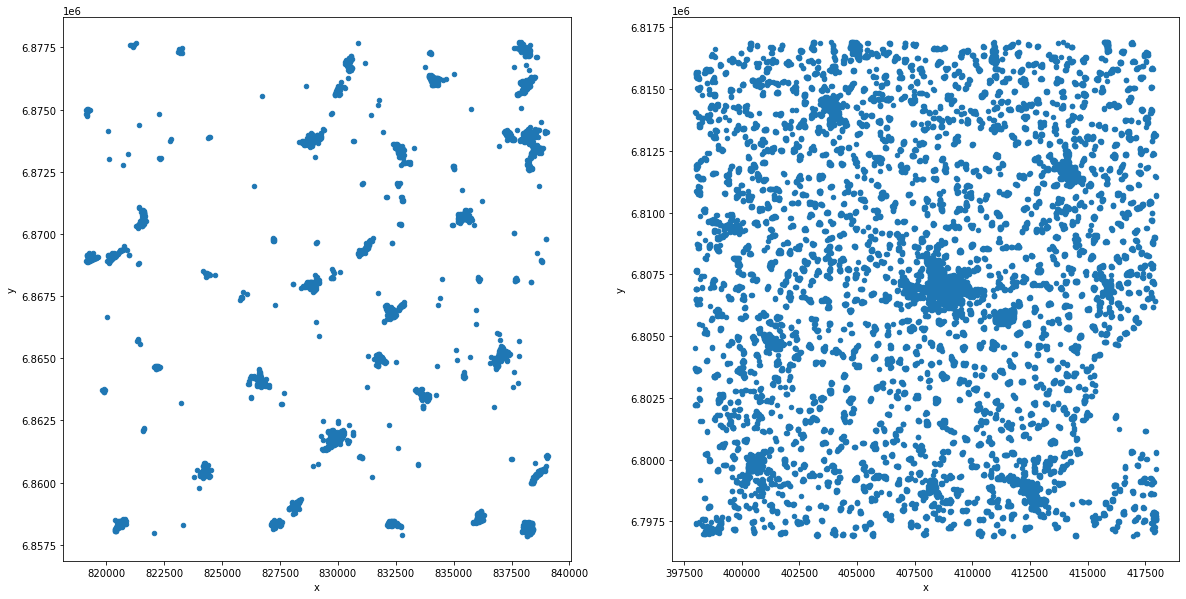

In [180]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
points_c.plot.scatter('x','y', ax=ax1)
points_d.plot.scatter('x','y', ax=ax2)

Nos rayons

In [26]:
radius=np.array([50,100,200,400,800])

On calcule le nombre de voisins puis l'inverse pour estimer par la méthode de sandbox la dimension de boxcounting

In [159]:
neighbors=np.zeros((points_c.shape[0],radius.size),dtype=float)
tree = KDTree(points_c)
for i in range(radius.size):
    neighbors[:,i]=tree.query_radius(points_c,r= radius[i],count_only=True,return_distance=False)
    output=np.column_stack([points_c,neighbors])
    names=np.hstack([['x','y'], np.core.defchararray.add('r_',np.char.mod('%d', radius))])
output_c=pd.DataFrame(output,columns=names)


sdbc_c = (output_c[['r_50', 'r_100', 'r_200', 'r_400', 'r_800']]**-1).sum(0)**-1

In [185]:
neighbors=np.zeros((points_d.shape[0],radius.size),dtype=float)
tree = KDTree(points_d)
for i in range(radius.size):
    neighbors[:,i]=tree.query_radius(points_d,r= radius[i],count_only=True,return_distance=False)
    output=np.column_stack([points_d,neighbors])
    names=np.hstack([['x','y'], np.core.defchararray.add('r_',np.char.mod('%d', radius))])
output_d=pd.DataFrame(output,columns=names)


sdbc_d = (output_d[['r_50', 'r_100', 'r_200', 'r_400', 'r_800']]**-1).sum(0)**-1

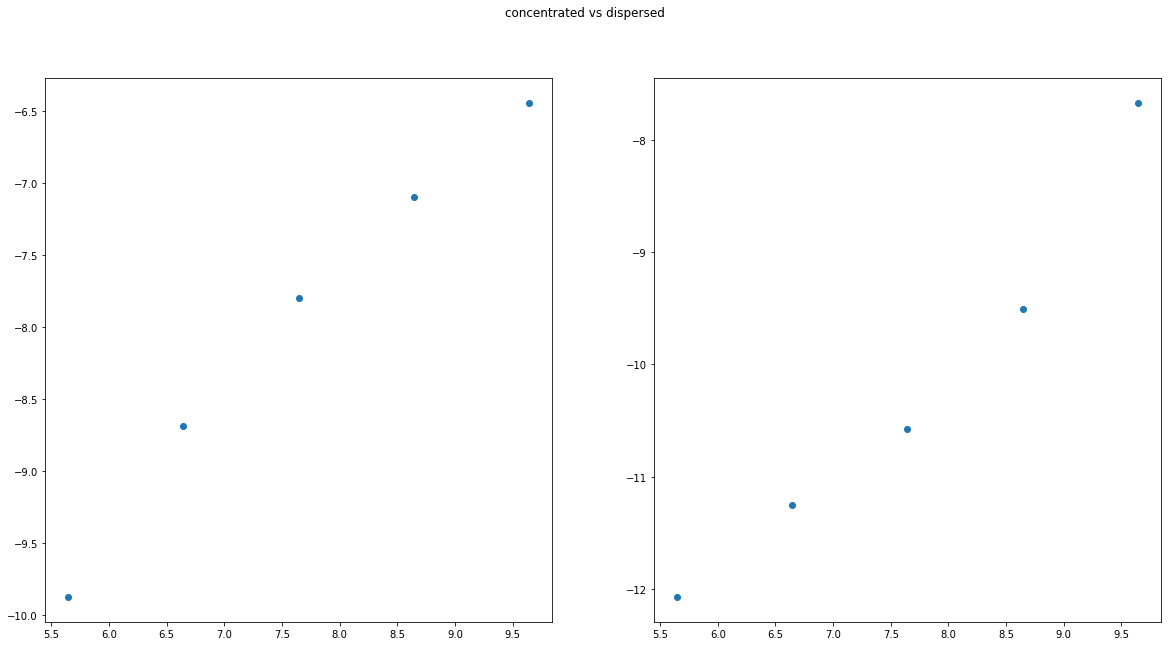

In [186]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('concentrated vs dispersed')
ax1.scatter(np.log2(radius), np.log2(sdbc_c))
ax2.scatter(np.log2(radius), np.log2(sdbc_d))

On obtient par cette régression les coeffs,a0, a1 et a2 de a0 + a1 * log(s) + a2 * log(s)^2. Comme les polygones sont normalisés a1 n'est pas directement la dimension fractale mais est a1=k*D. a2 est l'écart à l'invariance d'échelle.

In [138]:
poly2 = orthogonalize(np.concatenate([np.ones(len(radius)), np.log2(radius), np.log2(radius)**2]).reshape(3,len(radius)).T)

In [187]:
np.matmul(np.log2(sdbc_c), poly2)

array([-17.84468604,   2.67170571,  -0.33714737])

In [188]:
np.matmul(np.log2(sdbc_d), poly2)

array([-22.84596688,   3.33290428,   0.64754409])

On fait à présent le calcul sur le Calvados élargi avec la gwfa

In [2]:
import pyreadr

In [22]:
calvados = pd.read_parquet('coord_calvados_indif_indus_remar.parquet.gzip')

In [28]:
neighbors=np.zeros((calvados.shape[0],radius.size),dtype=float)
tree = KDTree(calvados)
for i in range(radius.size):
    neighbors[:,i]=tree.query_radius(calvados,r= radius[i],count_only=True,return_distance=False)
    output=np.column_stack([calvados,neighbors])
    names=np.hstack([['x','y'], np.core.defchararray.add('r_',np.char.mod('%d', radius))])
output_c=pd.DataFrame(output,columns=names)